# [Module 2.6] 예측 결과 분석 하기 (Analyze a Forecast)

이 노트북은 얼마나 예측이 잘 되었는지를 모듈 1에서 생성한 검증셋과 비교를 하여 정확도를 계산 합니다. 또한  Prophet, DeepAR+ 의 두개 정확도의 비교를 합니다.

아래와 같은 작업을 수행 합니다.

- S3의 Forecast 결과를 로컬에 다운로드
- Forecast 예측 결과 확인
- Forecast 예측 결과 포맷 변경
- Actual 값 준비
- forecast 예측 결과와 Actual 값의 조인
- 3개 알고리즘의 MAPE metric 확인
- Forecast에 단일 Query 실행 예제
- Prophet vs. DeeparP 차트 비교

---
이 노트북은 약 10분 정도 소요 됩니다. (About 10 mins may be elapsed)

In [1]:
import boto3
from time import sleep
import pandas as pd
import json
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
%store -r

In [3]:
session = boto3.Session(region_name=region)
forecast = session.client(service_name='forecast')
forecast_query = session.client(service_name='forecastquery')

## S3의 Forecast 결과를 로컬에 다운로드

아래의 작업은 S3에 저장된 예측 결과를 이 노트북 인스턴스에 다운로드 하는 과정 입니다. 로컬에 폴더를 만들고 다운로드 합니다. 

In [4]:
import os
prophet_result_dir = "prophet" + suffix
deepar_result_dir = "deeparp" + suffix
! mkdir -p {prophet_result_dir} # Create a folder for prophet forecast result
! mkdir -p {deepar_result_dir}

In [5]:
# Prophet
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)
prefix = bucket_folder + "/" +  "prophet_" + item_meta_suffix + suffix
prophet_filename = ""
prophet_files = list(poc_bucket.objects.filter(Prefix=prefix))
# print("prophet_files: ", prophet_files)
for file in prophet_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        prophet_filename = file.key.split('/')[2]
        s3.Bucket(bucket_name).download_file(file.key, prophet_result_dir+"/"+prophet_filename)
# print(prophet_filename)

In [6]:
# DeepAR+
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)
prefix = bucket_folder + "/" + "deeparp_" + item_meta_suffix + suffix
deeparp_filename = ""
deeparp_files = list(poc_bucket.objects.filter(Prefix=prefix))
for file in deeparp_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        deeparp_filename = file.key.split('/')[2]
        s3.Bucket(bucket_name).download_file(file.key, deepar_result_dir+"/"+deeparp_filename)
# print(deeparp_filename)

#### 다운로드 된 복수개의 파일을 1개의 데이타프레임으로 저장

In [7]:
def getTotalForecastResult(resultFolder):
    """
    Return a dataframe containing all forecast files in the folder passed
    """
    total_predicts_s3 = pd.DataFrame()
    for file in os.listdir(resultFolder):
        predicts_s3 = pd.read_csv(resultFolder + "/" + file)
        total_predicts_s3 = total_predicts_s3.append(predicts_s3)
    total_predicts_s3 = total_predicts_s3.sort_values(by=['item_id', 'date', 'StoreType'])                
    return total_predicts_s3
    
prophet_predicts_s3 = getTotalForecastResult(prophet_result_dir)    
deeparp_predicts_s3 = getTotalForecastResult(deepar_result_dir)    


In [8]:
prophet_predicts_s3.info()
deeparp_predicts_s3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 585 entries, 78 to 64
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   item_id    585 non-null    int64  
 1   StoreType  585 non-null    object 
 2   date       585 non-null    object 
 3   p10        585 non-null    float64
 4   p50        585 non-null    float64
 5   p90        585 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 32.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 585 entries, 78 to 64
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   item_id    585 non-null    int64  
 1   StoreType  585 non-null    object 
 2   date       585 non-null    object 
 3   p10        585 non-null    float64
 4   p50        585 non-null    float64
 5   p90        585 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 32.0+ KB


In [9]:
# Remove the folders already used
! rm -rf {prophet_result_dir}
! rm -rf {deepar_result_dir}

## Forecast 예측 결과 확인

아래는 deeparp 의 결과이고, 예로서 데이타의 해석의 방법은 첫번째 Row의 경우에 item_id 1 이 2017년 12월 1일에 Store1에서 p10 기준으로 약 14개가 팔리고, p50 기준으로 약 21가 팔리고, p90 기준으로 약 28개가 팔릴 것으로 예측을 하였습니다. 

In [10]:
prophet_predicts = prophet_predicts_s3.copy()
prophet_predicts.head()

,item_id,StoreType,date,p10,p50,p90
78,1,a,2012-07-30T00:00:00Z,1.448287e+06,1.563892e+06,1.712165e+06
79,1,a,2012-08-06T00:00:00Z,1.413703e+06,1.569706e+06,1.698607e+06
80,1,a,2012-08-13T00:00:00Z,1.452180e+06,1.580117e+06,1.700543e+06
81,1,a,2012-08-20T00:00:00Z,1.465172e+06,1.589717e+06,1.743422e+06
82,1,a,2012-08-27T00:00:00Z,1.494912e+06,1.601576e+06,1.749431e+06


## Forecast 예측 결과 포맷 변경

아래는 실제 Actual 값 (validation_time_series.csv) 과 비교를 위해서 포맷을 바꾸는 작업을 합니다.

In [11]:
# Remove the timezone
prophet_predicts['date'] = pd.to_datetime(prophet_predicts['date']) 
prophet_predicts['date'] = prophet_predicts['date'].dt.tz_convert(None) # Convert time zone
prophet_predicts.date = pd.to_datetime(prophet_predicts.date, format= '%Y-%m-%d') # Change a format of yyyy-mm-dd
prophet_predicts.item_id = prophet_predicts.item_id.astype(str) # convert to string type
prophet_predicts = prophet_predicts[['date','item_id','p10', 'p50', 'p90']]
prophet_predicts.head()

,date,item_id,p10,p50,p90
78,2012-07-30,1,1.448287e+06,1.563892e+06,1.712165e+06
79,2012-08-06,1,1.413703e+06,1.569706e+06,1.698607e+06
80,2012-08-13,1,1.452180e+06,1.580117e+06,1.700543e+06
81,2012-08-20,1,1.465172e+06,1.589717e+06,1.743422e+06
82,2012-08-27,1,1.494912e+06,1.601576e+06,1.749431e+06


In [12]:
# Remove the timezone
deeparp_predicts = deeparp_predicts_s3.copy()
deeparp_predicts['date'] = pd.to_datetime(deeparp_predicts['date']) 
deeparp_predicts['date'] = deeparp_predicts['date'].dt.tz_convert(None) # Convert time zone
deeparp_predicts.date = pd.to_datetime(deeparp_predicts.date, format= '%Y-%m-%d') # Change a format of yyyy-mm-dd
deeparp_predicts.item_id = deeparp_predicts.item_id.astype(str) # convert to string type
deeparp_predicts = deeparp_predicts[['date','item_id','p10', 'p50', 'p90']]
deeparp_predicts.head()

,date,item_id,p10,p50,p90
78,2012-07-30,1,1523444.750,1648981.75,1773234.375
79,2012-08-06,1,1520952.625,1634660.00,1734729.500
80,2012-08-13,1,1503159.375,1631228.00,1774652.125
81,2012-08-20,1,1490312.625,1629983.50,1744608.625
82,2012-08-27,1,1509666.250,1650928.50,1755399.250


## Actual 값 준비

Module 2.0 에서 준비한 검증 데이타 셋을 가져옵니다.

In [13]:
validation_df = validation_stores_sales.copy()
validation_df.reset_index(inplace=True) # reset index
validation_df = validation_df.rename(columns={'index':'date'}) # Change column name to date
validation_df.date = pd.to_datetime(validation_df.date, format= '%Y-%m-%d') # Change a format of yyyy-mm-dd
validation_df.head()



,date,Weekly_Sales,item_id
0,2012-07-30,1439123.71,1
1,2012-08-06,1631135.79,1
2,2012-08-13,1592409.97,1
3,2012-08-20,1597868.05,1
4,2012-08-27,1494122.38,1


## forecast 예측 결과와 Actual 값의 조인

실제로 예측된 결과 (Prophet) 와 검증 셋 데이타를 조인해서, 한개의 데이타 프레임으로 보이게 합니다. 여기서 실제로 얼마나 잘 예측을 했는지를 눈으로 확인할 수 있습니다.

In [14]:
prophet_val_df = pd.merge(prophet_predicts,validation_df, 
#                           on=['date', 'item_id'], 
                          on=['date', 'item_id'], 
                          how='inner')
                          
prophet_val_df.set_index('date', inplace=True)
prophet_val_df.head(10)

,item_id,p10,p50,p90,Weekly_Sales
date,,,,,
2012-07-30,1,1.448287e+06,1.563892e+06,1.712165e+06,1439123.71
2012-08-06,1,1.413703e+06,1.569706e+06,1.698607e+06,1631135.79
2012-08-13,1,1.452180e+06,1.580117e+06,1.700543e+06,1592409.97
2012-08-20,1,1.465172e+06,1.589717e+06,1.743422e+06,1597868.05
2012-08-27,1,1.494912e+06,1.601576e+06,1.749431e+06,1494122.38
2012-09-03,1,1.451544e+06,1.614372e+06,1.743005e+06,1582083.40
2012-09-10,1,1.489618e+06,1.576967e+06,1.715750e+06,1661767.33
2012-09-17,1,1.381797e+06,1.510480e+06,1.654622e+06,1517428.87
2012-09-24,1,1.342372e+06,1.493216e+06,1.606731e+06,1506126.06


In [15]:
deeparp_val_df = pd.merge(deeparp_predicts,validation_df, 
#                           on=['date', 'item_id'], 
                          on=['date', 'item_id'], 
                          how='inner')
                          
deeparp_val_df.set_index('date', inplace=True)
deeparp_val_df.head(10)

,item_id,p10,p50,p90,Weekly_Sales
date,,,,,
2012-07-30,1,1523444.750,1648981.750,1773234.375,1439123.71
2012-08-06,1,1520952.625,1634660.000,1734729.500,1631135.79
2012-08-13,1,1503159.375,1631228.000,1774652.125,1592409.97
2012-08-20,1,1490312.625,1629983.500,1744608.625,1597868.05
2012-08-27,1,1509666.250,1650928.500,1755399.250,1494122.38
2012-09-03,1,1491118.500,1599903.625,1732178.500,1582083.40
2012-09-10,1,1477687.375,1587759.625,1724996.875,1661767.33
2012-09-17,1,1505824.250,1581314.625,1705149.500,1517428.87
2012-09-24,1,1464795.500,1621375.375,1774733.250,1506126.06


## 3개 알고리즘의 MAPE metric 확인
- MAPE 는 에러 지표의 하나로서, 아래 mape_p50이 0.18이면 정확도는 1-0.18 = 0.82로서 약 82%의 정확도를 보임.

In [16]:
prophet_val_metric_df = prophet_val_df.copy()
n_rows = prophet_val_metric_df.shape[0]
prophet_val_metric_df['mape_p50'] = (abs(prophet_val_metric_df.Weekly_Sales - prophet_val_metric_df.p50) / prophet_val_metric_df.Weekly_Sales ) 
print("prophet MAPE: ", prophet_val_metric_df['mape_p50'].mean())
prophet_val_metric_df.head(4)


prophet MAPE:  0.04895752766755597


,item_id,p10,p50,p90,Weekly_Sales,mape_p50
date,,,,,,
2012-07-30,1,1.448287e+06,1.563892e+06,1.712165e+06,1439123.71,0.086698
2012-08-06,1,1.413703e+06,1.569706e+06,1.698607e+06,1631135.79,0.037661
2012-08-13,1,1.452180e+06,1.580117e+06,1.700543e+06,1592409.97,0.007720
2012-08-20,1,1.465172e+06,1.589717e+06,1.743422e+06,1597868.05,0.005101


In [17]:
deeparp_val_metric_df = deeparp_val_df.copy()
n_rows = deeparp_val_metric_df.shape[0]
deeparp_val_metric_df['mape_p50'] = (abs(deeparp_val_metric_df.Weekly_Sales - deeparp_val_metric_df.p50) / deeparp_val_metric_df.Weekly_Sales ) 
# prophet_val_metric_df.head(200)
print("deeparp: ", deeparp_val_metric_df['mape_p50'].mean())
deeparp_val_metric_df.head(4)

deeparp:  0.06378618680825668


,item_id,p10,p50,p90,Weekly_Sales,mape_p50
date,,,,,,
2012-07-30,1,1523444.750,1648981.75,1773234.375,1439123.71,0.145823
2012-08-06,1,1520952.625,1634660.00,1734729.500,1631135.79,0.002161
2012-08-13,1,1503159.375,1631228.00,1774652.125,1592409.97,0.024377
2012-08-20,1,1490312.625,1629983.50,1744608.625,1597868.05,0.020099


## Forecast에 단일 Query 실행 예제

**item_id** 으로 2012.8.1 ~ 2012.8.31예측 데이타를 볼 수 있는 예제 입니다.

In [18]:
forecast_query_response = forecast_query.query_forecast(
    ForecastArn = item_meta_prophet_forecast_arn,
    StartDate = "2012-08-01T00:00:00",
    EndDate = "2012-08-31T00:00:00",
    Filters={"item_id": "1"}
)
forecast_query_response

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2012-08-06T00:00:00',
     'Value': 1413703.375},
    {'Timestamp': '2012-08-13T00:00:00', 'Value': 1452180.125},
    {'Timestamp': '2012-08-20T00:00:00', 'Value': 1465172.375},
    {'Timestamp': '2012-08-27T00:00:00', 'Value': 1494911.5}],
   'p50': [{'Timestamp': '2012-08-06T00:00:00', 'Value': 1569706.375},
    {'Timestamp': '2012-08-13T00:00:00', 'Value': 1580116.75},
    {'Timestamp': '2012-08-20T00:00:00', 'Value': 1589717.0},
    {'Timestamp': '2012-08-27T00:00:00', 'Value': 1601575.875}],
   'p90': [{'Timestamp': '2012-08-06T00:00:00', 'Value': 1698607.375},
    {'Timestamp': '2012-08-13T00:00:00', 'Value': 1700543.5},
    {'Timestamp': '2012-08-20T00:00:00', 'Value': 1743422.125},
    {'Timestamp': '2012-08-27T00:00:00', 'Value': 1749430.5}]}},
 'ResponseMetadata': {'RequestId': 'a22cc258-cf4e-40c7-8748-81ed8b4ba255',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sun, 23

## Prophet vs. DeeparP
- 아래는 Prophet, DeepAR+의 두개의 예측 결과 및 실제 값을 그래프로 그려서 시각화를 합니다.

In [19]:
from utils import show_two_chart_horizontal

/home/ec2-user/SageMaker/Forecast/WalmartSale/utils.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1,2)
/home/ec2-user/SageMaker/Forecast/WalmartSale/utils.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1,2)
/home/ec2-user/SageMaker/Forecast/WalmartSale/utils.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

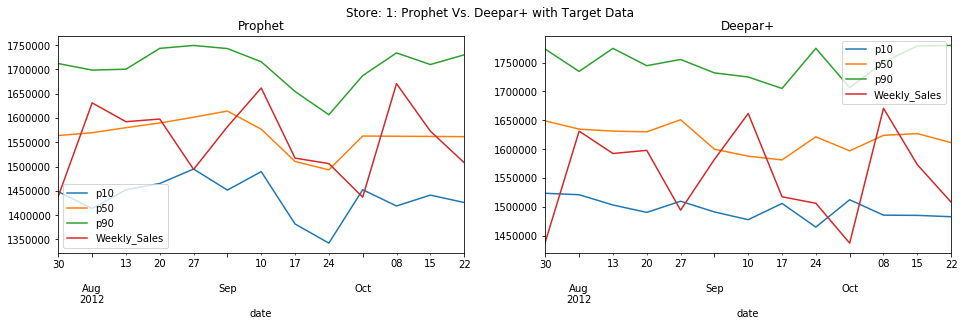

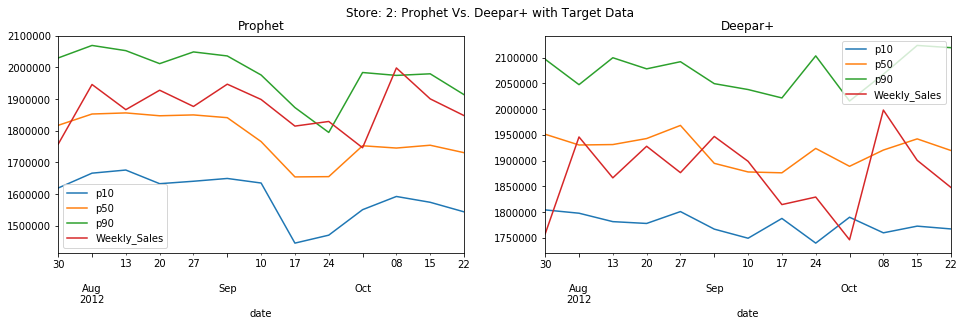

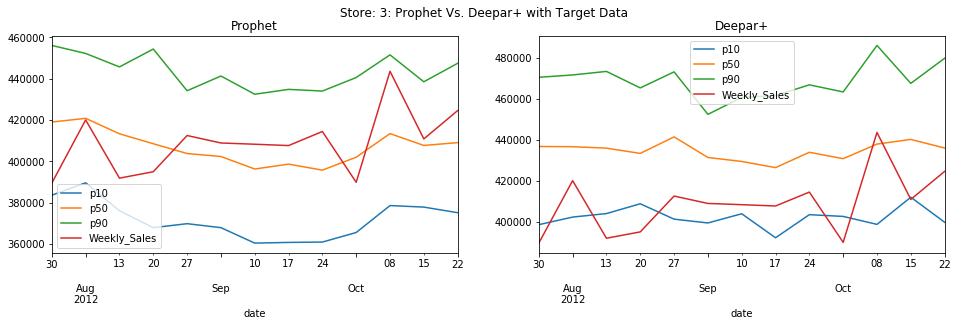

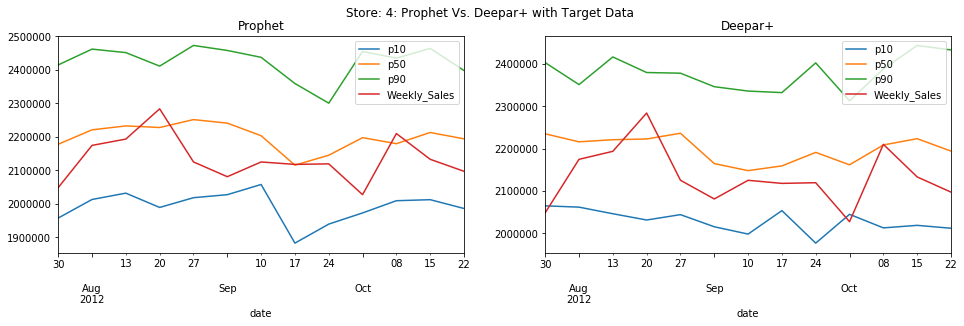

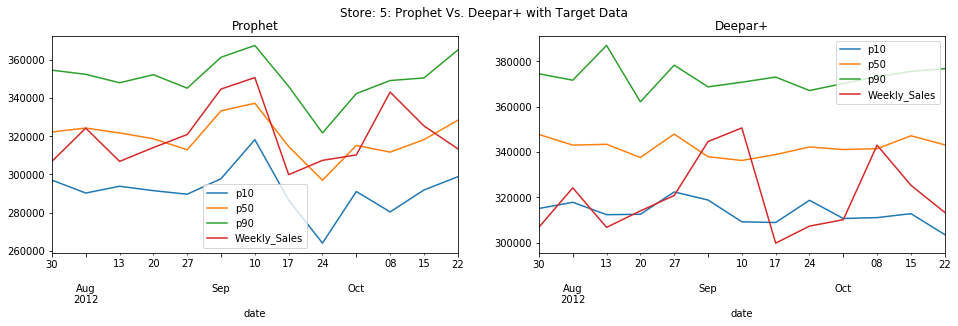

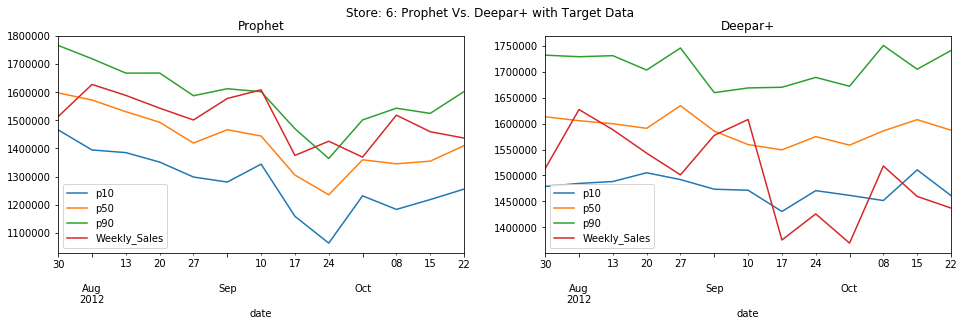

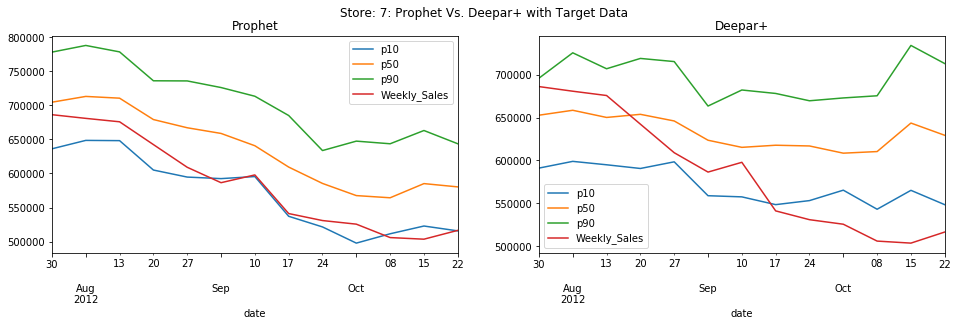

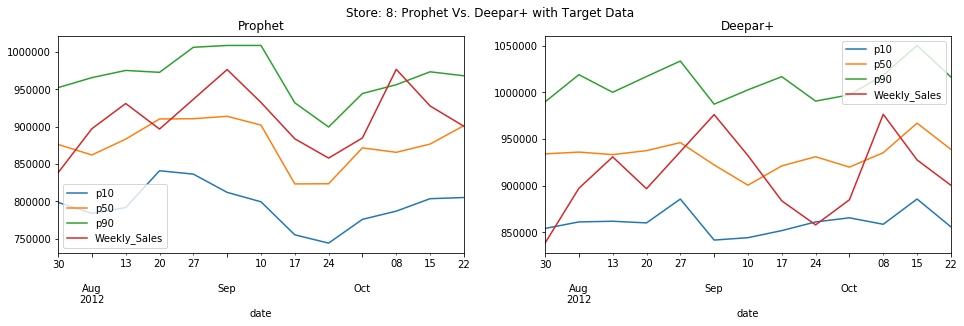

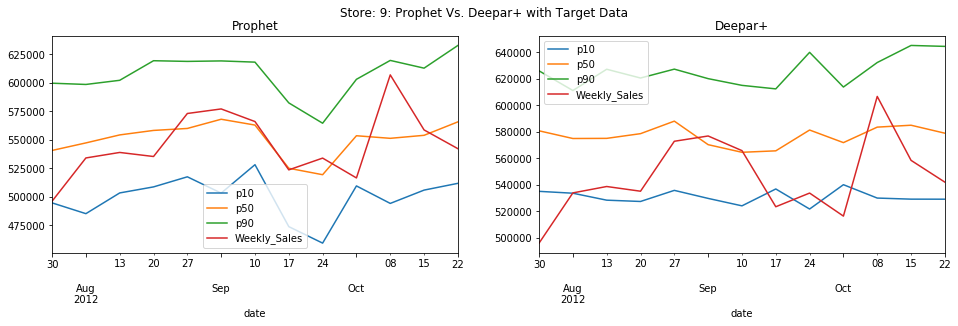

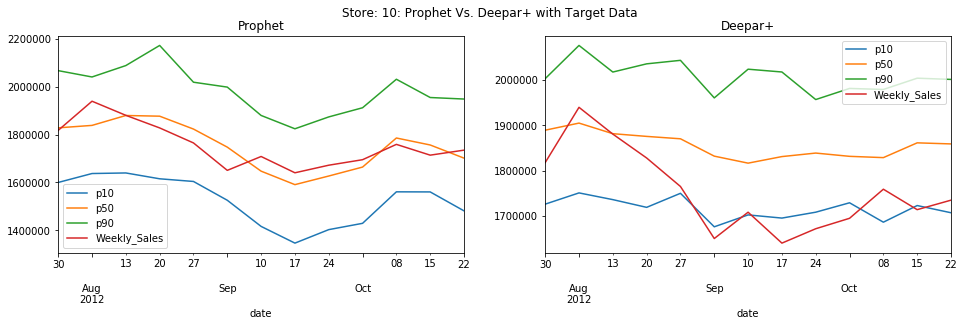

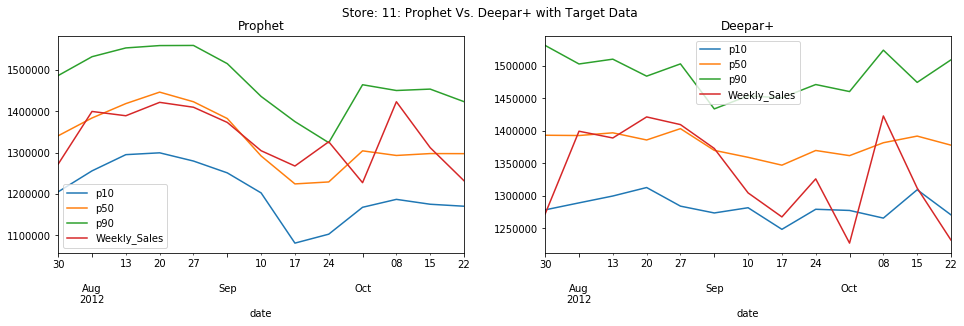

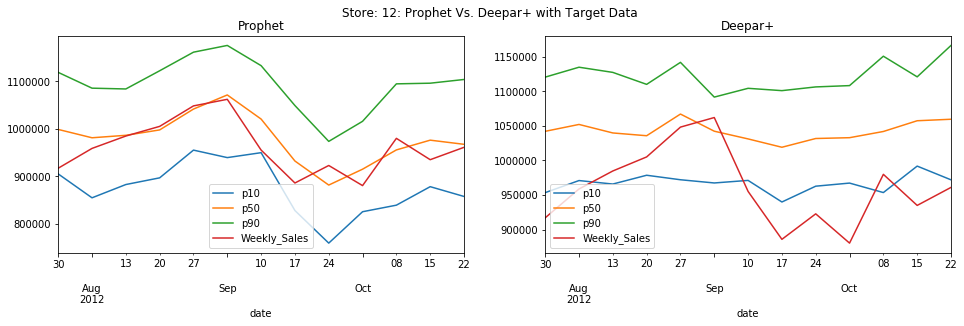

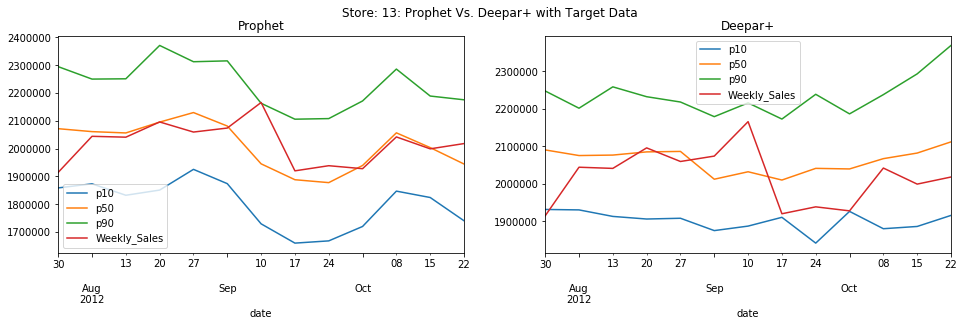

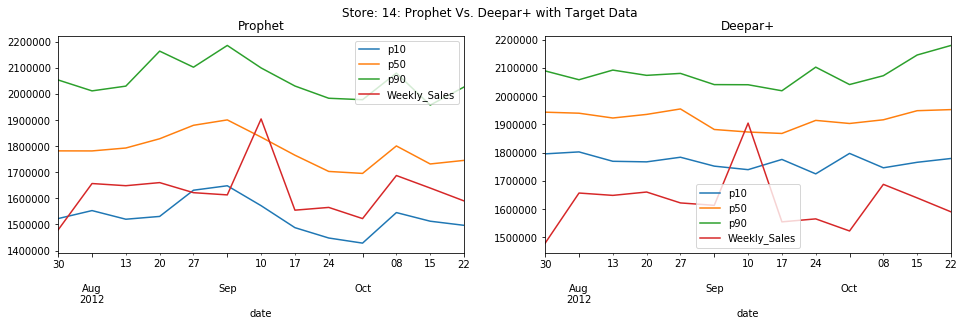

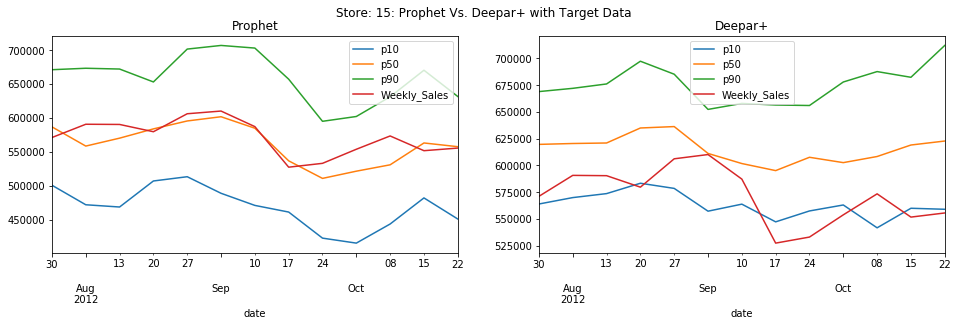

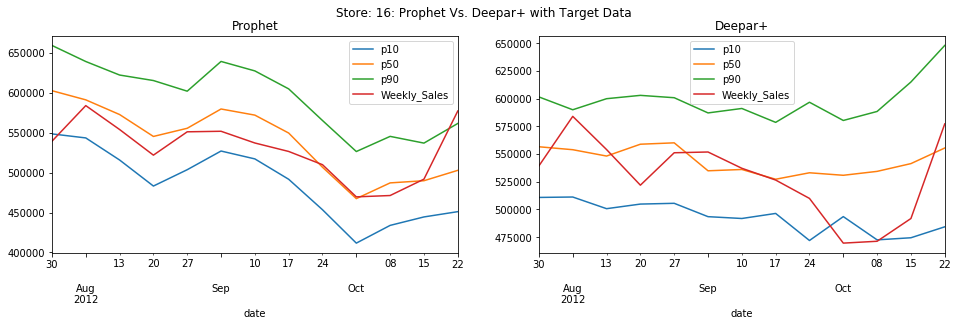

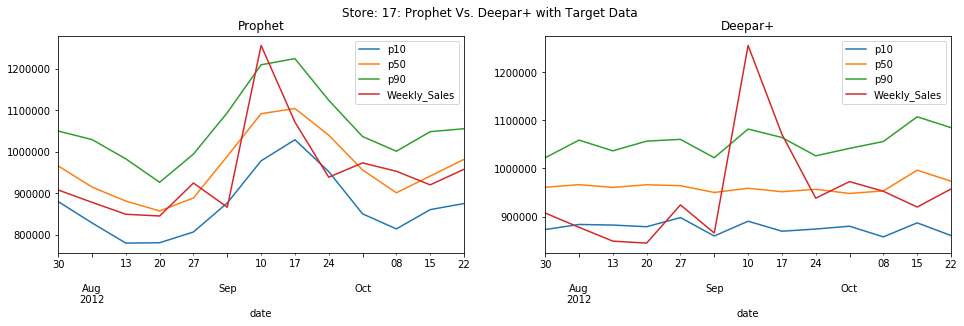

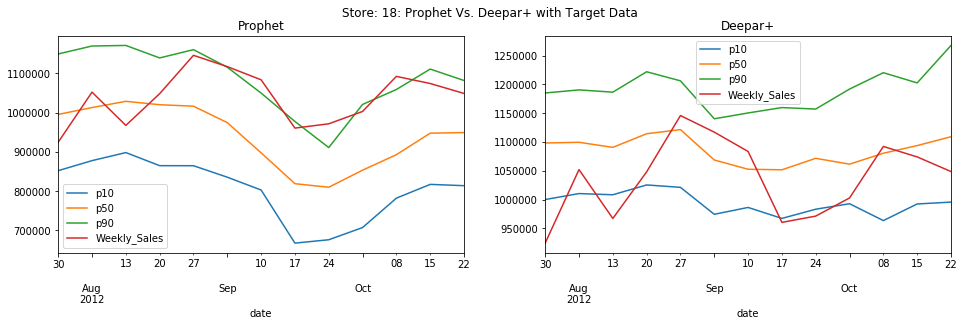

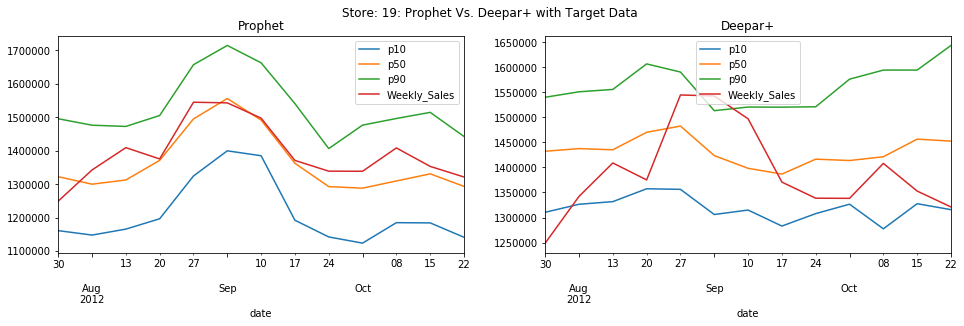

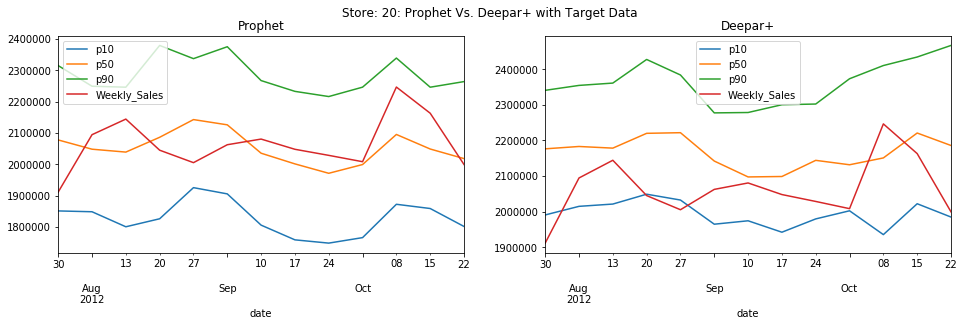

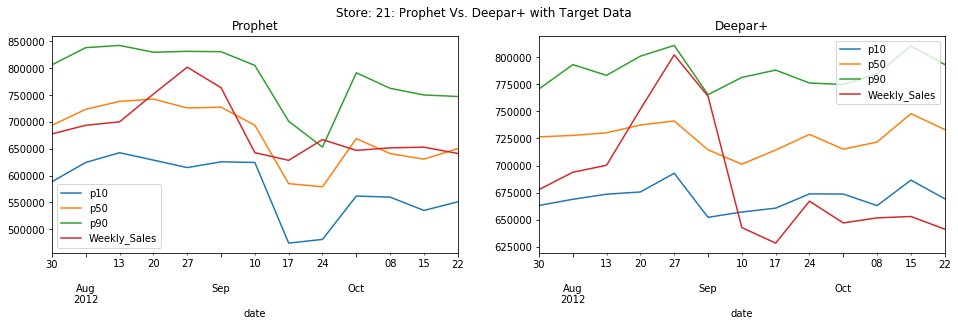

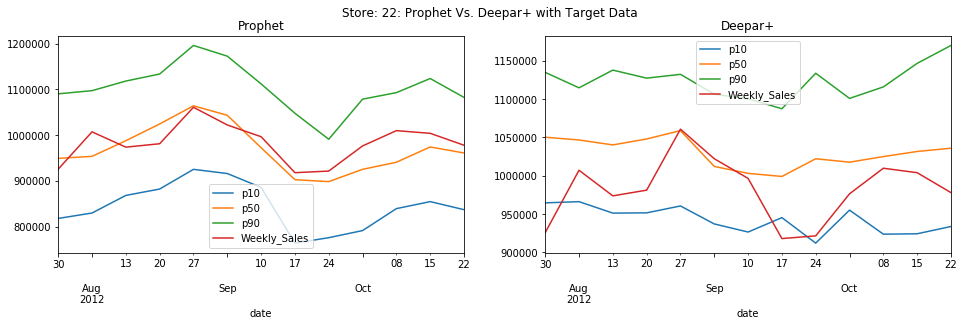

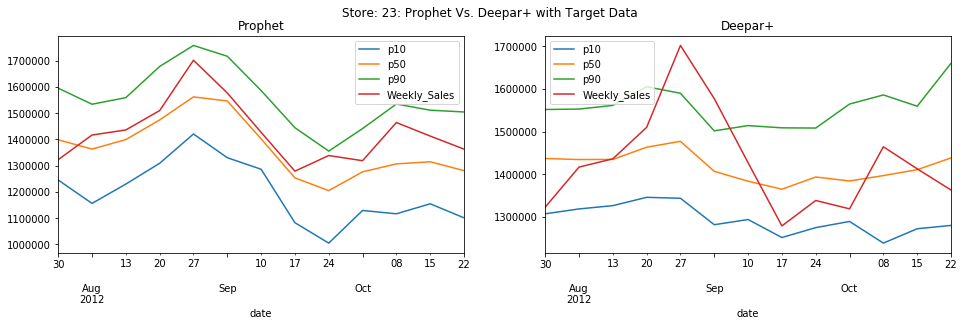

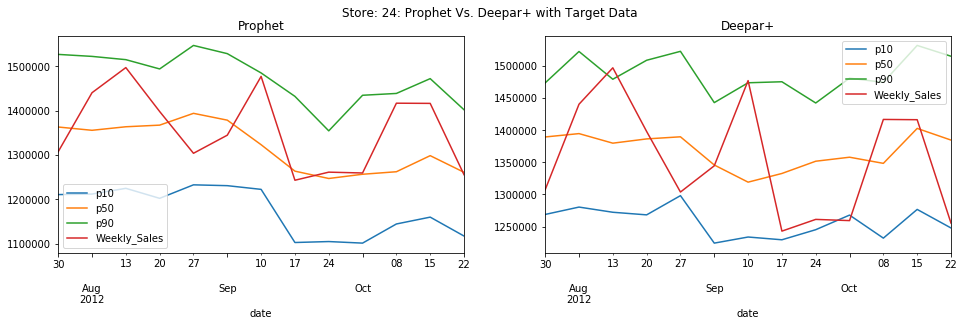

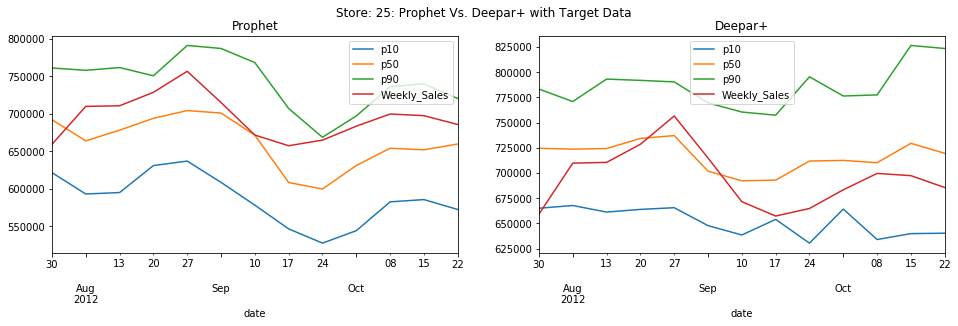

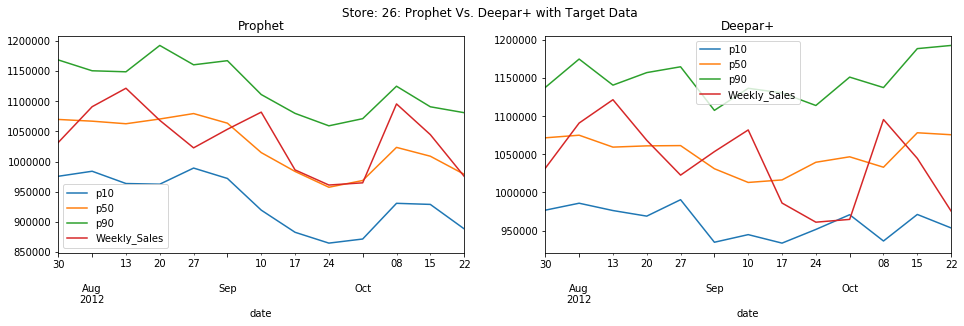

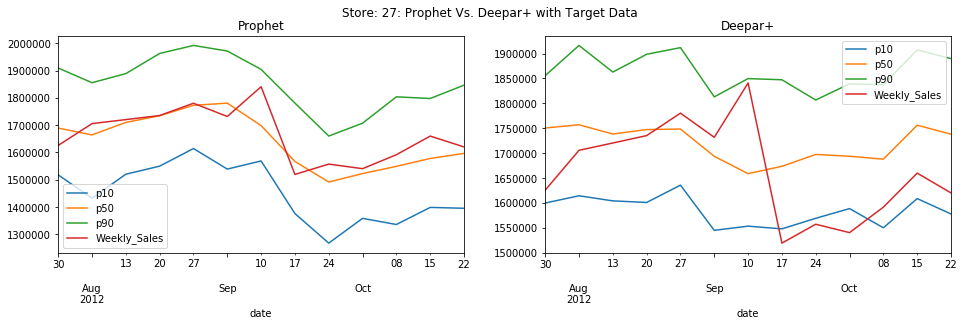

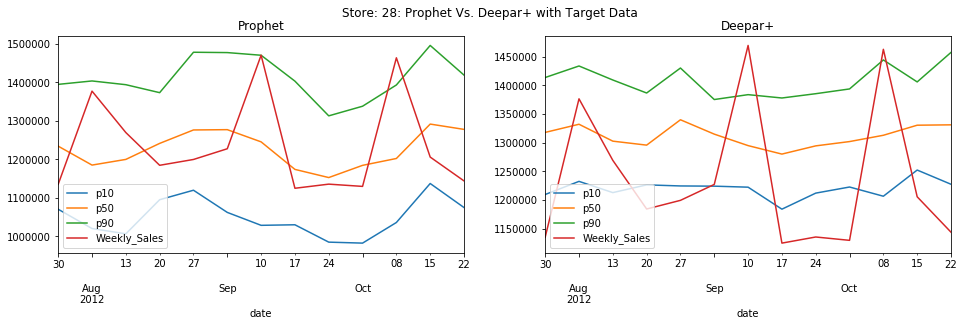

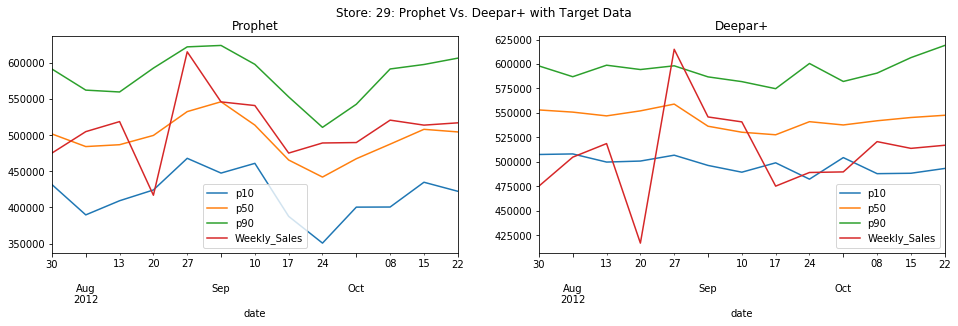

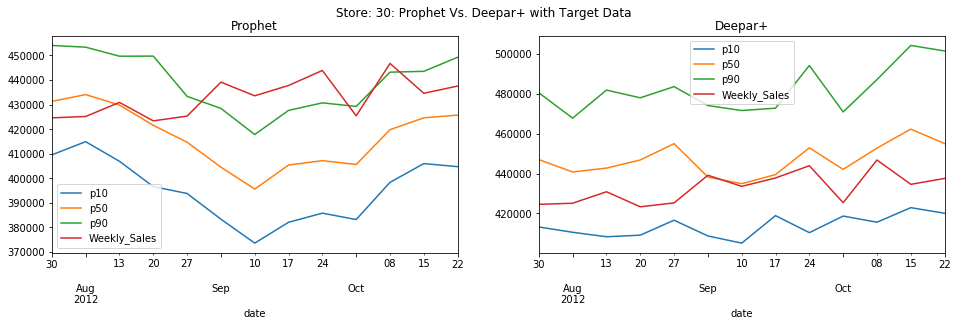

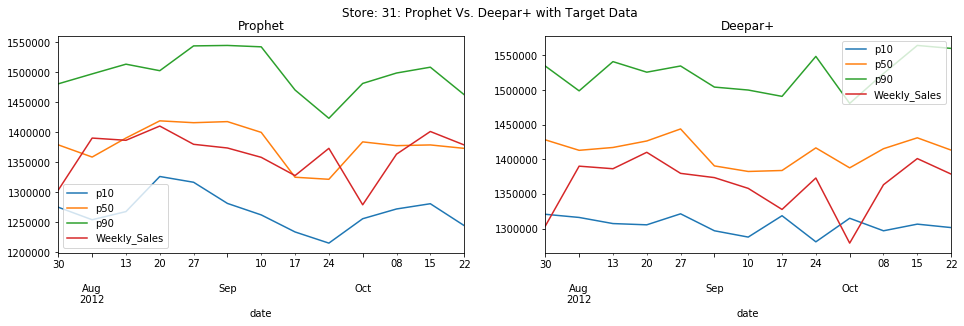

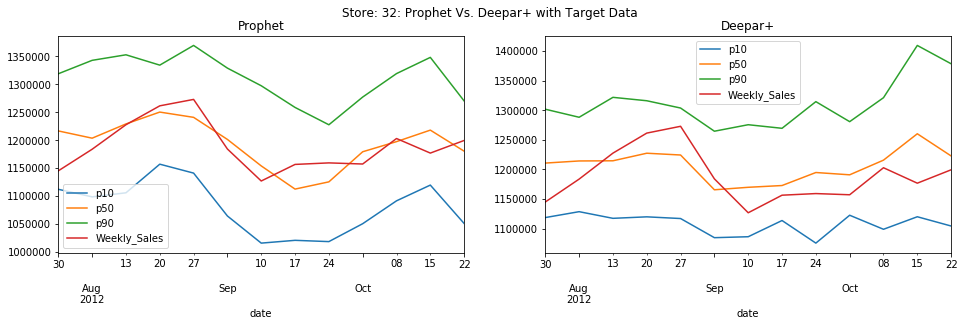

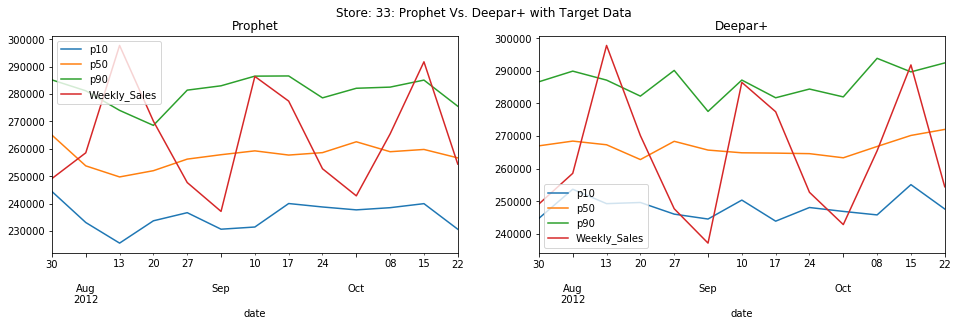

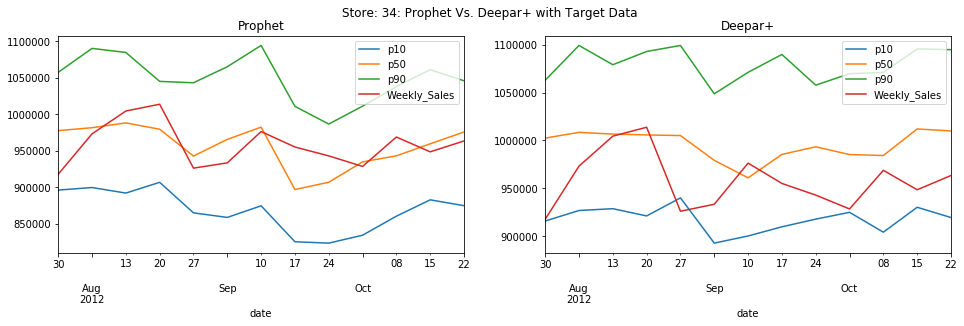

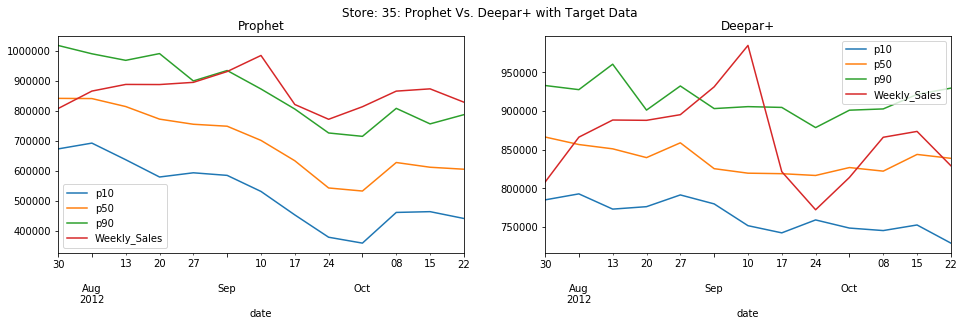

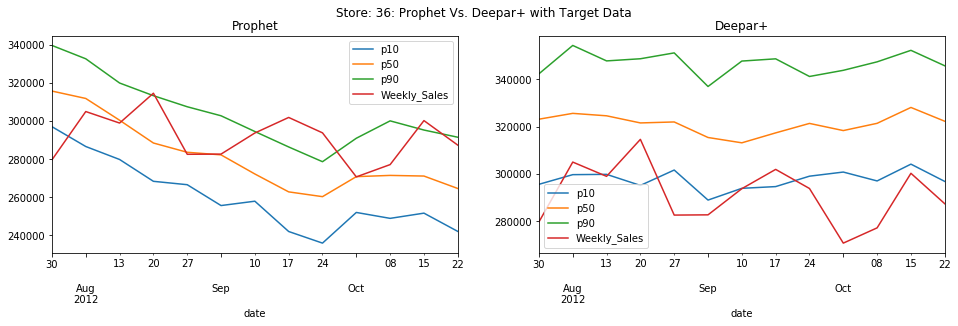

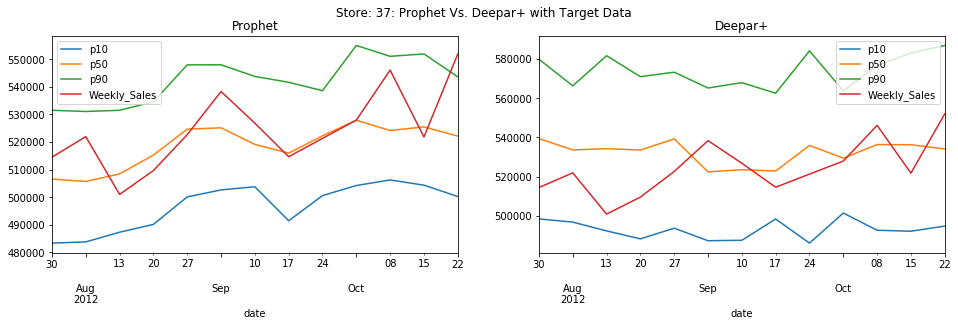

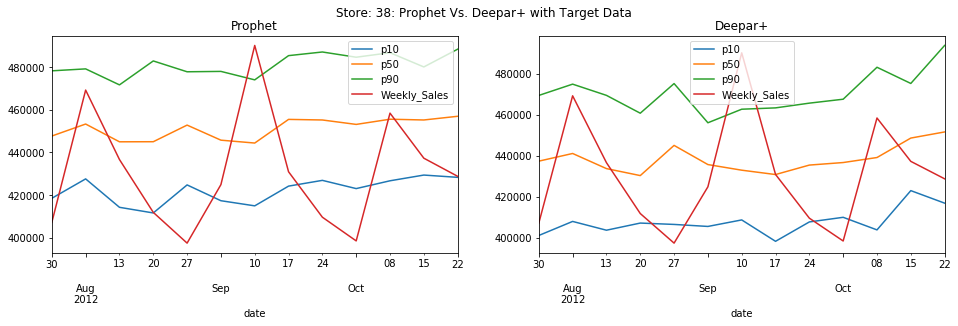

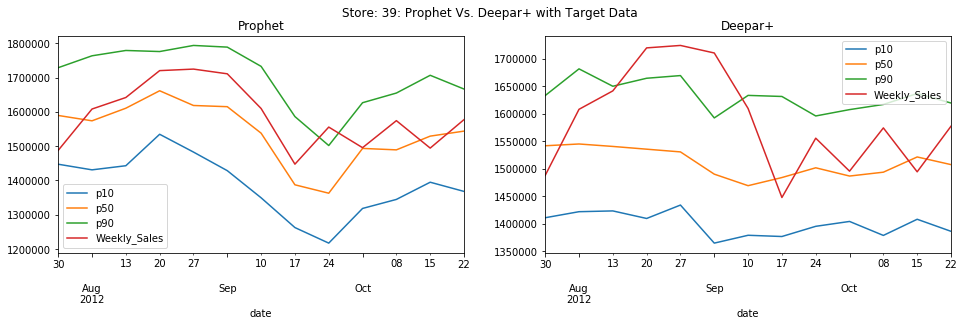

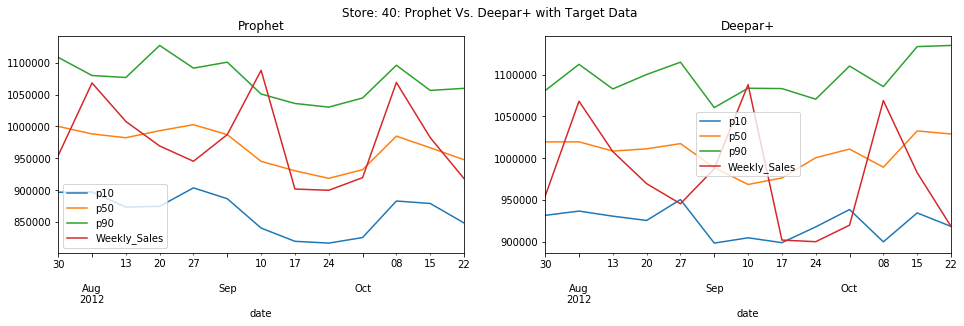

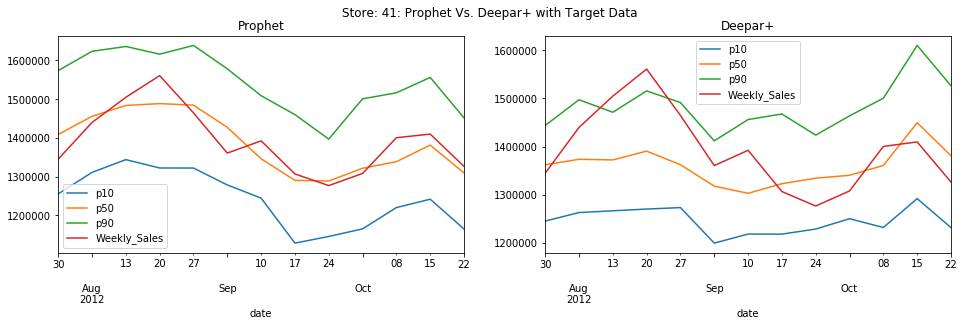

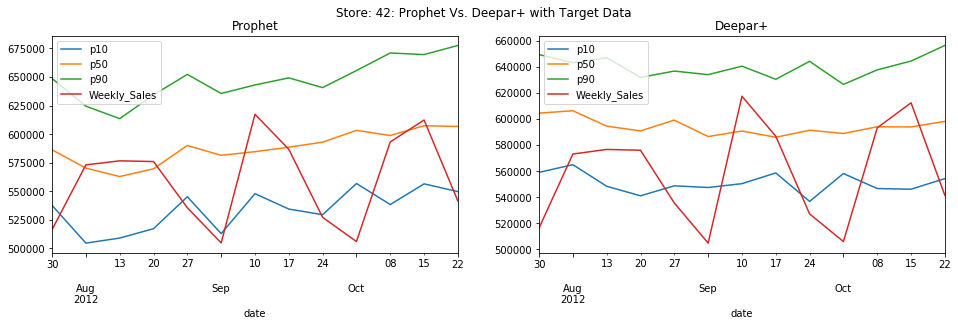

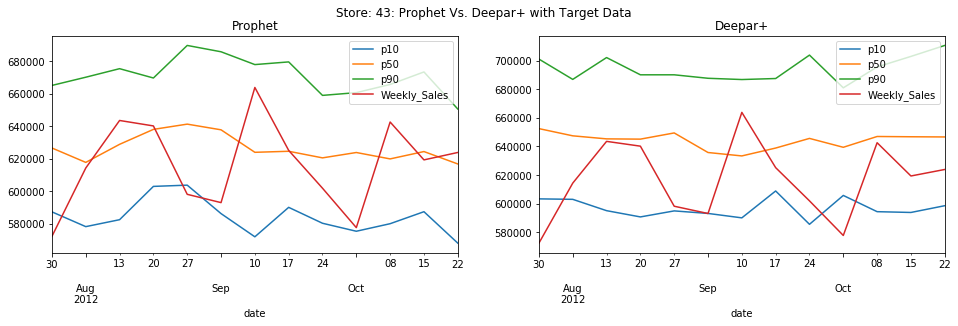

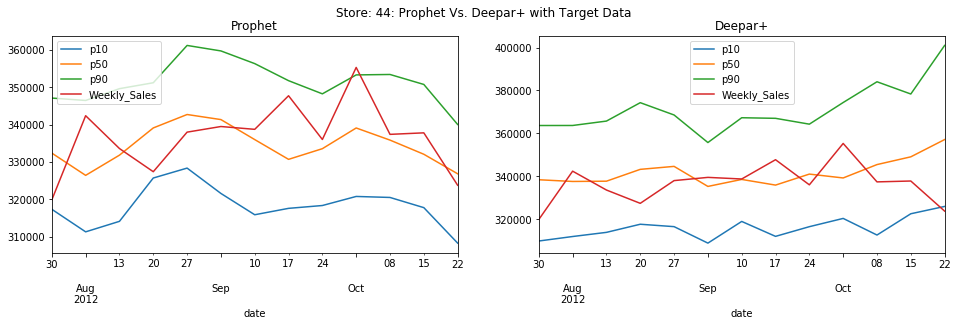

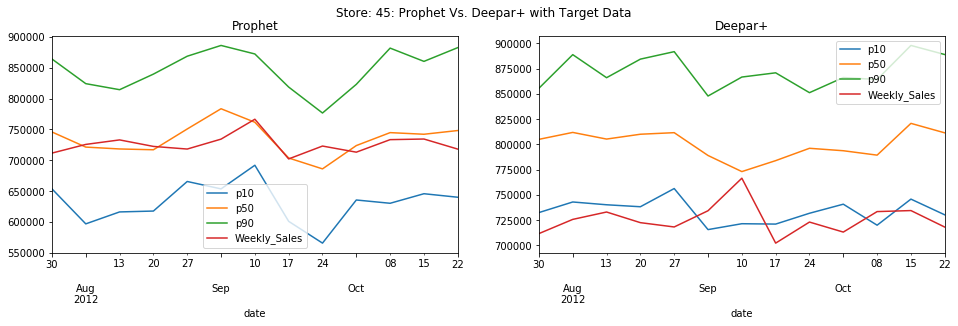

In [20]:
itme_id_list = prophet_val_df.item_id.unique()
itme_id_list = pd.DataFrame(itme_id_list, columns=['item_id'])
itme_id_list.item_id = itme_id_list.item_id.astype('int64')
itme_id_list.item_id.sort_values()

for i in itme_id_list.item_id.sort_values():
    prophet_val_single_df = prophet_val_df[prophet_val_df.item_id == str(i)]
    deeparp_val_single_df = deeparp_val_df[deeparp_val_df.item_id == str(i)]    
    plot_title = "Store: " + str(i) + ": Prophet Vs. Deepar+ with Target Data"
    show_two_chart_horizontal(plot_title, 
                          prophet_val_single_df, 
                          "Prophet", 
                          deeparp_val_single_df,
                          "Deepar+", 
                         )